In [3]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random

O dataset é constituído por imagens de dimensões 32 x 32 x 3 com os 3 canais RGB.

In [4]:
img = cv2.imread("test/FAKE/0.jpg")
np.array(img).shape

(32, 32, 3)

In [5]:
def load(arr, path):
    for filename in os.listdir(path):
        arr.append(np.reshape(cv2.imread(os.path.join(path, filename)), (3072,)))

In [ ]:
if not os.path.exists("test.txt"):
    test_x = []
    load(test_x, "test/FAKE/")
    load(test_x, "test/REAL/")
    train_x = []
    load(train_x, "train/FAKE/")
    load(train_x, "train/REAL/")

    np.array(test_x).tofile("test.txt", dtype=np.uint8)
    np.array(train_x).tofile("train.txt", dtype=np.uint8)

In [6]:
test_x = np.fromfile("test.txt", dtype=np.uint8).reshape((20000, 32, 32, 3))
train_x = np.fromfile("train.txt", dtype=np.uint8).reshape((100000,32, 32,3))
print(test_x.shape, train_x.shape)


(20000, 32, 32, 3) (100000, 32, 32, 3)


In [7]:
test_y = np.append(np.zeros((10000,)), np.ones((10000,)))
train_y = np.append(np.zeros((50000,)), np.ones((50000,)))
print(test_y.shape, train_y.shape)

(20000,) (100000,)


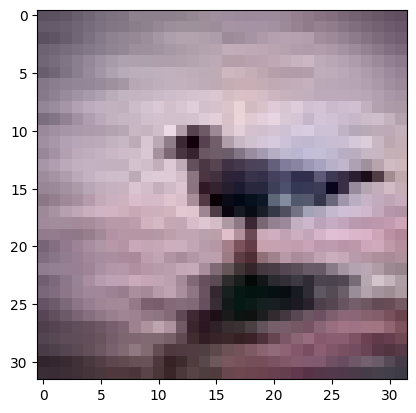

In [8]:
plt.imshow(test_x[2])

In [9]:
def shuffled_data(data_x, data_y):
    new_data = list(zip(data_x, data_y))
    random.shuffle(new_data)
    new_data = np.array(new_data, dtype=object).transpose()
    return (np.array([x for x in new_data[0]]), new_data[1])
    

In [10]:
def auxiliar_data(data_x, data_y, size):
    half = int(len(data_x) / 2)
    fake_x, fake_y = shuffled_data(data_x[:half], data_y[:half])
    real_x, real_y = shuffled_data(data_x[half:], data_y[half:])
    x = np.append(fake_x[:int(size/2)], real_x[:int(size/2)], 0).astype(np.uint8)
    y = np.append(fake_y[:int(size/2)], real_y[:int(size/2)], 0).astype(np.uint8)
    return (x,y)


In [11]:
flat_train_x = train_x.reshape(len(train_x), 3072)
flat_test_x = test_x.reshape(len(test_x), 3072)

In [12]:
aux_test_x, aux_test_y = auxiliar_data(flat_test_x, test_y, 400)
aux_train_x, aux_train_y = auxiliar_data(flat_train_x, train_y, 2000)


In [13]:
aux_train_x.shape

(2000, 3072)

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [15]:
knn_scores = []
for i in range(1, 20):
    mean = []
    for k in range(10):
        aux_test_x, aux_test_y = auxiliar_data(flat_test_x, test_y, 400)
        aux_train_x, aux_train_y = auxiliar_data(flat_train_x, train_y, 2000)
        knn_model = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
        knn_model.fit(aux_train_x, aux_train_y)
        mean.append(knn_model.score(aux_test_x, aux_test_y))
    knn_scores.append(mean)


In [16]:
knn_scores

NameError: name 'knn_scores' is not defined

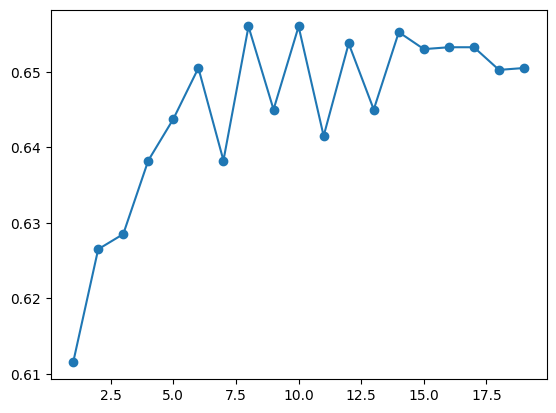

In [ ]:
plt.plot(range(1, 20), knn_scores, '-o')
points_x = [np.full((len(knn_scores[0]),), i) for i in range(1,20)]
for x, y in zip(points_x, knn_scores):
    plt.scatter(x, y, color='gray', alpha=0.5)
plt.grid(axis='y')

In [ ]:
if not os.path.exists('knn_scores.npy'):
    with open('knn_scores.npy', 'wb') as f:
        np.save(f, np.array(knn_scores,dtype=object), allow_pickle=True)

In [ ]:
with open('knn_scores.npy', 'rb') as f:
    knn_scores = np.load(f, allow_pickle=True)

In [ ]:
n = range(1, 10)[np.argmax(knn_scores)]
n

8

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)
knn_model.fit(train_x.reshape((len(train_x), 3072)), train_y)
final_knn_score = knn_model.score(test_x.reshape((len(test_x), 3072)), test_y)

In [ ]:
if not os.path.exists('final_knn_score.npy'):
    with open('final_knn_score.npy', 'wb') as f:
        np.save(f, np.array(final_knn_score,dtype=object), allow_pickle=True)

In [17]:
from sklearn.tree import DecisionTreeClassifier
import itertools as it

In [79]:
tree_scores = []
criterions = ["gini", "entropy", "log_loss"]
max_depths = range(2, 10, 2)

for comb in it.product(criterions, max_depths):
    mean = []
    for k in range(5):
        aux_test_x, aux_test_y = auxiliar_data(flat_test_x, test_y, 400)
        aux_train_x, aux_train_y = auxiliar_data(flat_train_x, train_y, 2000)
        tree_model = DecisionTreeClassifier(criterion=comb[0], max_depth=comb[1])
        tree_model.fit(aux_train_x, aux_train_y)
        mean.append(tree_model.score(aux_test_x, aux_test_y))
    tree_scores.append(mean)

In [ ]:
if not os.path.exists('tree_scores.npy'):
    with open('tree_scores.npy', 'wb') as f:
        np.save(f, np.array(tree_scores,dtype=object), allow_pickle=True)

In [168]:
tree_scores_avg = [np.mean(x) for x in tree_scores]

In [80]:
combs = list(zip(it.product(criterions, max_depths), tree_scores_avg))
combs

[(('gini', 2), 0.6005),
 (('gini', 4), 0.6134999999999999),
 (('gini', 6), 0.6525000000000001),
 (('gini', 8), 0.6615),
 (('entropy', 2), 0.6024999999999999),
 (('entropy', 4), 0.618),
 (('entropy', 6), 0.6339999999999999),
 (('entropy', 8), 0.6235),
 (('log_loss', 2), 0.604),
 (('log_loss', 4), 0.5905),
 (('log_loss', 6), 0.6235),
 (('log_loss', 8), 0.608)]

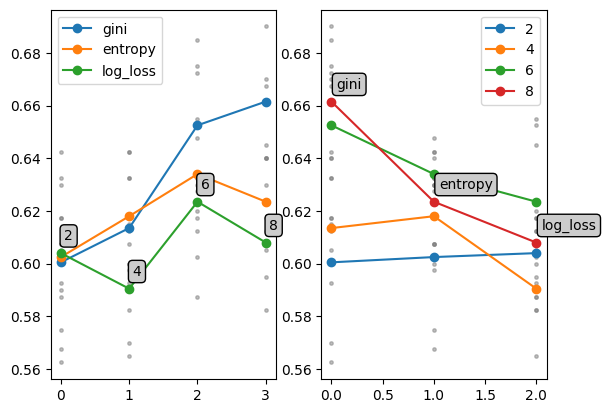

In [190]:
relation_matrix = np.array(combs, dtype=object).transpose()[0].reshape((len(criterions),len(max_depths)))

plt.subplot(1, 2, 1)
indexes = None
for param in relation_matrix:
    indexes = [np.where([y[0] == x for y in combs])[0][0] for x in param]
    plt.plot(range(len(max_depths)), [x[1] for x in [combs[i] for i in indexes]], '-o', label=param[0][0])
    plt.legend()

    points_x = [np.full((len(tree_scores[0]),), i) for i in range(len(param))]
    points_y = [tree_scores[i] for i in indexes]

    plt.scatter(points_x, points_y, color='gray', alpha=0.5, s=6)
for x, y in zip(range(len(indexes)),[tree_scores_avg[i] for i in indexes]):
    plt.annotate(str(max_depths[x]), (x+0.05, y+0.005), bbox={'boxstyle':"round", 'fc':"0.8"})

plt.subplot(1, 2, 2)
for param in relation_matrix.transpose():
    indexes = [np.where([y[0] == x for y in combs])[0][0] for x in param]
    plt.plot(range(len(param)), [x[1] for x in [combs[i] for i in indexes]], '-o', label=param[0][1])
    plt.legend()
    
    points_x = [np.full((len(tree_scores[0]),), i) for i in range(len(param))]
    points_y = [tree_scores[i] for i in indexes]
    
    plt.scatter(points_x, points_y, color='gray', alpha=0.5, s=6)

for x, y in zip(range(len(indexes)),[tree_scores_avg[i] for i in indexes]):
    plt.annotate(str(criterions[x]), (x+0.05, y+0.005), bbox={'boxstyle':"round", 'fc':"0.8"})

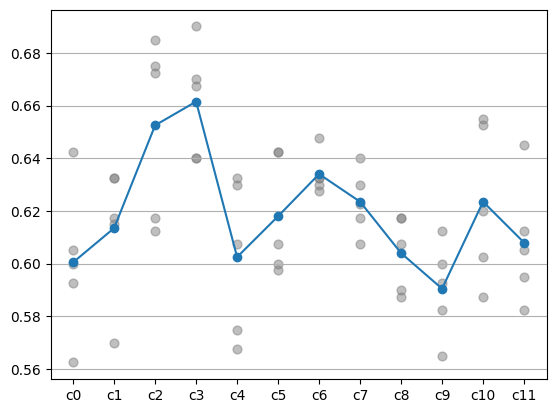

In [166]:
plt.plot([f'c{i}' for i in range(len(tree_scores))], [np.mean(x) for x in tree_scores], '-o')
points_x = [np.full((len(tree_scores[0]),),i)for i in range(len(tree_scores))]
for x, y in zip(points_x, tree_scores):
    plt.scatter(x, y, color='gray', alpha=0.5, s=40)
plt.grid(axis='y')
None

In [ ]:

aux_test_x, aux_test_y = auxiliar_data(flat_test_x, test_y, 400)
aux_train_x, aux_train_y = auxiliar_data(flat_train_x, train_y, 2000)

In [ ]:
comb = list(it.product(criterions, max_depths))[np.argmax(tree_scores)]

In [ ]:
tree_model = DecisionTreeClassifier(criterion=comb[0], max_depth=comb[1])
tree_model.fit(train_x, train_y)
tree_model.score(test_x, test_y)

KeyboardInterrupt: 

In [199]:
import skops.io as sio
if not os.path.exists('tree_model.skops'):
    obj = sio.dumps(tree_model)
    sio.dump(obj, "tree_model.skops")


In [201]:
tree_model = sio.loads(sio.load("test.skops"))

['dwq', 1, (1, 'qde')]

In [ ]:
import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.models import Sequential
from keras.optimizers import Adamax
from keras.losses import SparseCategoricalCrossentropy

In [ ]:
ann_model = Sequential()

ann_model.add(Dense(256, activation="relu"))
ann_model.add(Dense(128, activation="relu"))
ann_model.add(Dense(64, activation="relu"))
ann_model.add(Dense(2, activation="sigmoid"))

In [ ]:
ann_model.compile(optimizer=Adamax(), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [ ]:
ann_model.fit(flat_train_x, train_y,epochs=5)

Epoch 1/5
3125/3125 [==============================] - 46s 15ms/step - loss: 0.4413 - accuracy: 0.7925
Epoch 2/5
3125/3125 [==============================] - 46s 15ms/step - loss: 0.4386 - accuracy: 0.7934
Epoch 3/5
3125/3125 [==============================] - 64s 21ms/step - loss: 0.4325 - accuracy: 0.7968
Epoch 4/5
3125/3125 [==============================] - 61s 20ms/step - loss: 0.4326 - accuracy: 0.7960
Epoch 5/5
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4265 - accuracy: 0.8002


In [ ]:
ann_model.evaluate(flat_test_x, test_y)

625/625 [==============================] - 6s 9ms/step - loss: 0.4966 - accuracy: 0.7679


[0.49663349986076355, 0.7678999900817871]

In [ ]:
if not os.path.exists('ann_model.txt'):
    ann_model.save("ann_model.txt")

In [ ]:
cnn_model = Sequential()

cnn_model.add(Conv2D(128, 3, input_shape=(32,32,3), activation="relu"))
cnn_model.add(MaxPool2D())
cnn_model.add(Conv2D(128, 2))
cnn_model.add(MaxPool2D())

cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation="relu"))
cnn_model.add(Dense(128, activation="relu"))
cnn_model.add(Dense(64, activation="relu"))
cnn_model.add(Dense(2, activation="sigmoid"))

In [ ]:
cnn_model.compile(optimizer=Adamax(), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [202]:
cnn_model.summary()

NameError: name 'cnn_model' is not defined

In [ ]:
cnn_model.fit(train_x, train_y, epochs=5)

Epoch 1/10
3125/3125 [==============================] - 714s 228ms/step - loss: 0.5035 - accuracy: 0.8249
Epoch 2/10
3125/3125 [==============================] - 687s 220ms/step - loss: 0.2685 - accuracy: 0.8898
Epoch 3/10
3125/3125 [==============================] - 687s 220ms/step - loss: 0.2157 - accuracy: 0.9129
Epoch 4/10
3125/3125 [==============================] - 683s 219ms/step - loss: 0.1739 - accuracy: 0.9309
Epoch 5/10
3125/3125 [==============================] - 724s 232ms/step - loss: 0.1401 - accuracy: 0.9449
Epoch 6/10
3125/3125 [==============================] - 707s 226ms/step - loss: 0.1073 - accuracy: 0.9586
Epoch 7/10
3125/3125 [==============================] - 769s 246ms/step - loss: 0.0819 - accuracy: 0.9688
Epoch 8/10
3125/3125 [==============================] - 799s 256ms/step - loss: 0.0613 - accuracy: 0.9768
Epoch 9/10
3125/3125 [==============================] - 712s 228ms/step - loss: 0.0451 - accuracy: 0.9826
Epoch 10/10
3125/3125 [=======================

In [ ]:
cnn_model.evaluate(test_x, test_y)

625/625 [==============================] - 44s 68ms/step - loss: 0.2950 - accuracy: 0.9258


[0.29498761892318726, 0.9257500171661377]

In [ ]:
if not os.path.exists('cnn_model.txt'):
    cnn_model.save("cnn_model.txt")